EfficientB7

In [35]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

In [25]:
# 1. Global Setup : Nếu thiết bị có hỗ trợ GPU thì sẽ dùng GPU để quá trình xử lý được
# thực hiện nhanh hơn, nếu không thì sẽ chạy mặc định là CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# Lấy đường dẫn hiện tại của thư mục
base_dir = os.getcwd()

In [27]:
# 2. Data Loading : Tiến hành ghi nhận lại đường dẫn của các folder ảnh và load các ảnh này lên hệ thống
# đồng thời tạo 1 file .csv ghi nhận lại id ảnh và nhãn ảnh
def load_dataset():
    folders = {
        'backyard': os.path.join(base_dir, 'REI-Dataset', 'backyard'),
        'bathroom': os.path.join(base_dir, 'REI-Dataset', 'bathroom'),
        'bedroom': os.path.join(base_dir, 'REI-Dataset', 'bedroom'),
        'frontyard': os.path.join(base_dir, 'REI-Dataset', 'frontyard'),
        'kitchen': os.path.join(base_dir, 'REI-Dataset', 'kitchen'),
        'livingRoom': os.path.join(base_dir, 'REI-Dataset', 'livingRoom'),
    }
    data = []
    for label, folder in folders.items():
        folder_files = []
        for file_name in sorted(os.listdir(folder)):
            if file_name.endswith(('.jpg', '.jpeg', '.png')):
                file_base_name = os.path.splitext(file_name)[0]
                folder_files.append({'filename': file_base_name, 'label': label})
        print(f"Loaded {len(folder_files)} images from {label}.")
        data.extend(folder_files)
        
    df = pd.DataFrame(data)
    csv_path = os.path.join(base_dir, 'image_labels.csv')
    df.to_csv(csv_path, index=False)
    print(f"CSV file created with {len(df)} entries at {csv_path}.")
    return df, folders

In [28]:
# 3. Rút trích đặc trưng, nếu file đặc trưng chưa được tính toán thì tiến hành tính và ghi lại
# Nếu đã có thì tiến hành load file đặc trưng
def extract_features(dataset, folders, modelE):
    all_features = {}
    base_dir = os.getcwd()
    for label, folder in folders.items():
        feature_file = base_dir + '/features/' + f'{label.lower()}_features.npy'
        
        if os.path.exists(feature_file):
#             print(f"Loading features from {feature_file}...")
            features = np.load(feature_file)
#             print(f"Loaded {features.shape[0]} features from {label}.")
            labels = [label] * features.shape[0] 
            image_files = [item['filename'] for item in dataset if item['label'] == label]
        else:
#         print(f"Extracting features for {label}...")
            features = []
            labels = []
            image_files = []

            folder_files = [item for item in dataset if item['label'] == label]
            for item in folder_files:
                image_path = os.path.join(folder, item['filename'] + '.jpg')
                if os.path.exists(image_path):
                    image = cv2.imread(image_path)
                      # Tiền xử lý hình ảnh cho mô hình EfficientNetB7
                    image = cv2.resize(image, (600, 600))  # Kích thước đầu vào của EfficientNetB7 là 600x600
                    image = preprocess_input(image)  # Chuẩn hóa đầu vào giống như trong Keras
                    image = np.expand_dims(image, axis=0)
                    # Chạy mô hình dự đoán
                    feature = modelE.predict(image).squeeze()

                    # Lưu trữ kết quả
                    features.append(feature)
                    labels.append(label)
                    image_files.append(image_path)  # Lưu trữ đường dẫn đầy đủ của hình ảnh

            features = np.array(features)
            np.save(feature_file, features)
            print(f"Saved {features.shape[0]} features to {feature_file}.")
        
        all_features[label] = (features, labels, image_files)
    
    return all_features

In [29]:
# 4. Xử lý ảnh đầu vào sao cho phù hợp mới model EfficientNet-B7
def extract_query_features_and_predict_label(image_path, modelE, svm_model, transform):
    # Đọc hình ảnh
    image = cv2.imread(image_path)
    
    # Tiền xử lý hình ảnh
    image = cv2.resize(image, (600, 600))  # Kích thước đầu vào của EfficientNetB7 là 600x600
    processed_image = preprocess_input(image)  # Chuẩn hóa đầu vào giống như trong Keras
    
    # Thêm một trục mới để tạo batch
    processed_image = np.expand_dims(processed_image, axis=0)
    
    # Dự đoán đặc trưng từ mô hình EfficientNetB7
    features = modelE.predict(processed_image).squeeze()
    
    # Dự đoán nhãn của ảnh truy vấn sử dụng SVM
    predicted_label = svm_model.predict([features])[0]
    
    return features, predicted_label

In [30]:
# 5. Huấn luyện cho mô hình SVM để phân lớp với tham số C đặt mặc định là 1, sử dụng RBF kernel
def train_svm_classifier(X_train, y_train):
    svm = SVC(kernel='rbf', C=1)
    svm.fit(X_train, y_train)
    return svm

In [31]:
# Hàm để vẽ đồ thị
def plot_label_accuracy(csv_file):
    df = pd.read_csv(csv_file)
    
    # Danh sách các nhãn cần vẽ
    labels_to_plot = ['bathroom', 'bedroom', 'frontyard', 'kitchen', 'livingRoom', 'backyard']
    
    # Khởi tạo dictionary để lưu số lượng true positives cho từng nhãn tại mỗi bước
    label_counts = {label: [] for label in labels_to_plot}
    total_counts = {label: 0 for label in labels_to_plot}
    
    for _, row in df.iterrows():
        true_label = row['true_label']
        predicted_label = row['predicted_label']
        
        if true_label == predicted_label:
            total_counts[true_label] += 1
        
        for label in labels_to_plot:
            label_counts[label].append(total_counts[label])
    
    # Vẽ đồ thị
    plt.figure(figsize=(10, 6))
    
    for label in labels_to_plot:
        plt.plot(label_counts[label], label=label)
    
    plt.xlabel('Index')
    plt.ylabel('Number of True Positives')
    plt.title('Number of True Positives for Each Label')
    plt.legend()
    plt.show()

# 6. Dự đoán và đánh giá độ chính xác của mô hình
def evaluate_classifier(svm, X_test, y_test, test_files, le):
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    prediction_data = [{'filename': file_name, 'true_label': le.inverse_transform([y_true])[0], 'predicted_label': le.inverse_transform([y_pred])[0]} 
                       for file_name, y_true, y_pred in zip(test_files, y_test, y_pred)]
    prediction_df = pd.DataFrame(prediction_data)
    prediction_df.to_csv('Predict_with_labels.csv', index=False)
    plot_label_accuracy('Predict_with_labels.csv')
    plot_confusion_matrix('Predict_with_labels.csv')
    

In [39]:
# 7. Xây dựng các hàm truy vấn ảnh
def get_image_paths(main_folder):
    image_paths = []
    for sub_folder in os.listdir(main_folder):
        sub_folder_path = os.path.join(main_folder, sub_folder)
        if os.path.isdir(sub_folder_path):
            for image_name in os.listdir(sub_folder_path):
                image_path = os.path.join(sub_folder_path, image_name)
                image_paths.append(image_path)
    return image_paths

# Ở hàm này, thực hiện rút trích đặc trưng của ảnh truy vấn bằng cách cho ảnh đi qua mô hình EfficientNet-B7
# để tính đặc trưng, tiến hành tính khoảng cách đặc trưng của ảnh truy vấn với từng đặc trưng của từng ảnh
# sau đó sort lại để có những ảnh có khoảng cách tăng dần -> có độ tương đồng giảm dần
# Hàm để trích xuất đặc trưng và tìm ảnh tương tự
def retrieve_similar_images(input_image_path, predicted_label, all_features, modelE, top_n=21):
    # Đọc và tiền xử lý ảnh
    img = image.load_img(input_image_path, target_size=(600, 600))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Rút trích đặc trưng
    input_features = modelE.predict(img_array).flatten()
    
    # Chọn các tính năng và đường dẫn hình ảnh tương ứng với nhãn dự đoán
    features, labels, image_files = all_features[predicted_label]
    
    distances = [np.linalg.norm(input_features - f) for f in features]
    sorted_indices = np.argsort(distances)[:top_n]
    
    return [(image_files[i], labels[i]) for i in sorted_indices]
    
def display_images(retrieved_images, query_label, images_per_row=10):
    num_images = len(retrieved_images)
    num_rows = (num_images + images_per_row - 1) // images_per_row

    plt.figure(figsize=(images_per_row * 3, num_rows * 3))
    
    # Các đuôi mở rộng được hỗ trợ
    extensions = ['.jpg', '.jpeg', '.png']
    image_path_1 = base_dir + '/REI-Dataset'
    
    for i, (image_name, label) in enumerate(retrieved_images):
        image_path_2 = image_path_1 + '/' + label + '/' + image_name
        if not any(image_path_2.endswith(ext) for ext in extensions):
            for ext in extensions:
                potential_path = image_path_2 + ext
                if os.path.exists(potential_path):
                    image_path_2 = potential_path
                    break
            else:
                # Nếu không tìm thấy file nào tồn tại với các đuôi mở rộng trên, mặc định sử dụng .jpg
                image_path_2 = image_path_2 + '.jpg'
        image = cv2.imread(image_path_2)
        
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            plt.subplot(num_rows, images_per_row, i + 1)
            plt.imshow(image)
            plt.title(f"Image {i + 1}")

            plt.axis('off')
        else:
            print(f"Error: Unable to load image at")
    
    plt.tight_layout()
    plt.show()

    
def retrieve_similar_images_from_query(image_path, svm_model, all_features, modelE, le, top_n):
    # Rút trích đặc trưng của ảnh truy vấn và dự đoán nhãn
    query_features, predicted_label = extract_query_features_and_predict_label(
        image_path, modelE, svm_model, preprocess_input
    )

    # Chuyển đổi nhãn dự đoán từ số về chuỗi
    predicted_label_str = le.inverse_transform([predicted_label])[0]

    # Kiểm tra nếu nhãn tồn tại trong all_features
    if predicted_label_str not in all_features:
        raise ValueError(f"Predicted label '{predicted_label_str}' not found in the dataset.")

    # Sử dụng hàm retrieve_similar_images để tìm ảnh tương tự dựa trên nhãn dự đoán
    retrieved_images = retrieve_similar_images(
        image_path, predicted_label_str, all_features, modelE, top_n
    )

    return retrieved_images, predicted_label_str

In [33]:
# 8. Tính độ đo AP cho mỗi lần thực hiện truy vấn
def calculate_ap(query_label, retrieved_images, top_n):
    true_positives = 0
    sum_precision = 0

    for i in range(top_n):
        result_label = retrieved_images[i][1]
        
        if result_label == query_label:
            true_positives += 1
            precision_at_i = true_positives / (i + 1)  # Precision tại điểm i
            sum_precision += precision_at_i

    if true_positives == 0:
        return 0

    average_precision = sum_precision / true_positives
    return average_precision

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 9. Vẽ confusion matrix đánh giá kết quả của mô hình
def plot_confusion_matrix(csv_file):
    df = pd.read_csv(csv_file)
    
    # Danh sách các nhãn
    labels = ['bathroom', 'bedroom', 'frontyard', 'kitchen', 'livingRoom', 'backyard']
    
    # Lấy các nhãn thực và dự đoán từ dataframe
    y_true = df['true_label']
    y_pred = df['predicted_label']
    
    # Tính toán ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Hiển thị ma trận nhầm lẫn
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(15, 12))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    
    # Nghiêng các chữ chú thích ở trục ngang
    plt.xticks(rotation=45)
    
    plt.title('Confusion Matrix')
    plt.show()

Loaded 633 images from backyard.
Loaded 674 images from bathroom.
Loaded 1354 images from bedroom.
Loaded 751 images from frontyard.
Loaded 843 images from kitchen.
Loaded 724 images from livingRoom.
CSV file created with 4979 entries at c:\Users\ACER\OneDrive\Desktop\VISION_INFOR_RETRIEVAL\Project\REI-Classification-Retrieval\image_labels.csv.
features_combined shape: (4753, 2560)
Training and test datasets created successfully.
Accuracy: 96.00%


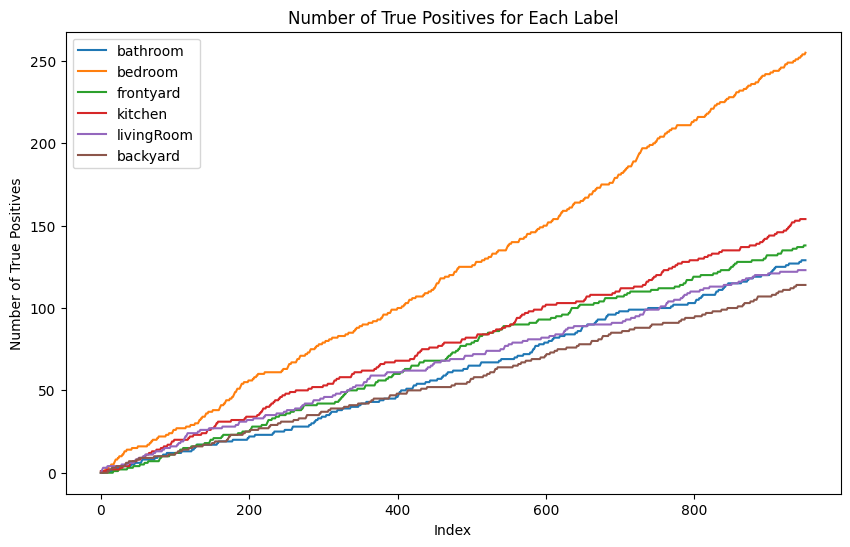

<Figure size 1500x1200 with 0 Axes>

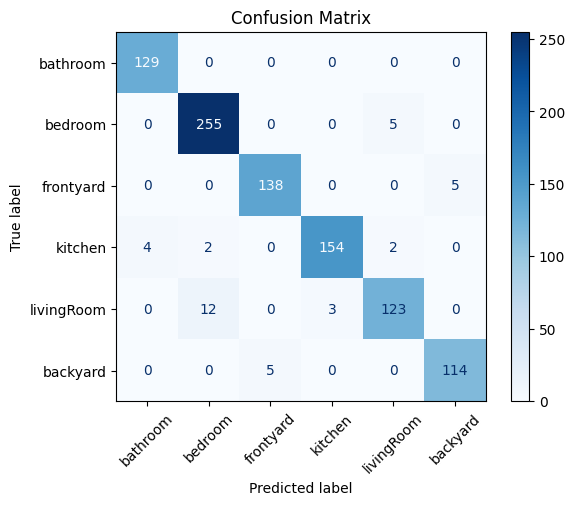

Enter the path to an image (type 'exit' to quit):
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


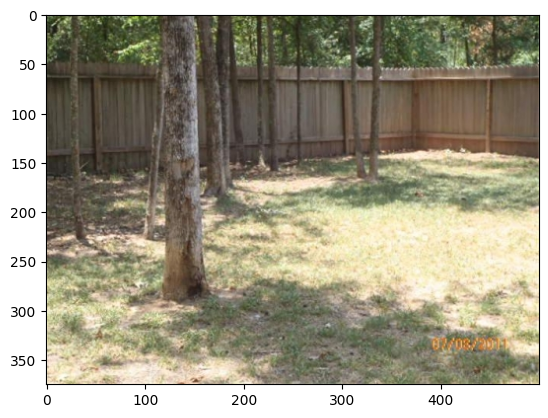

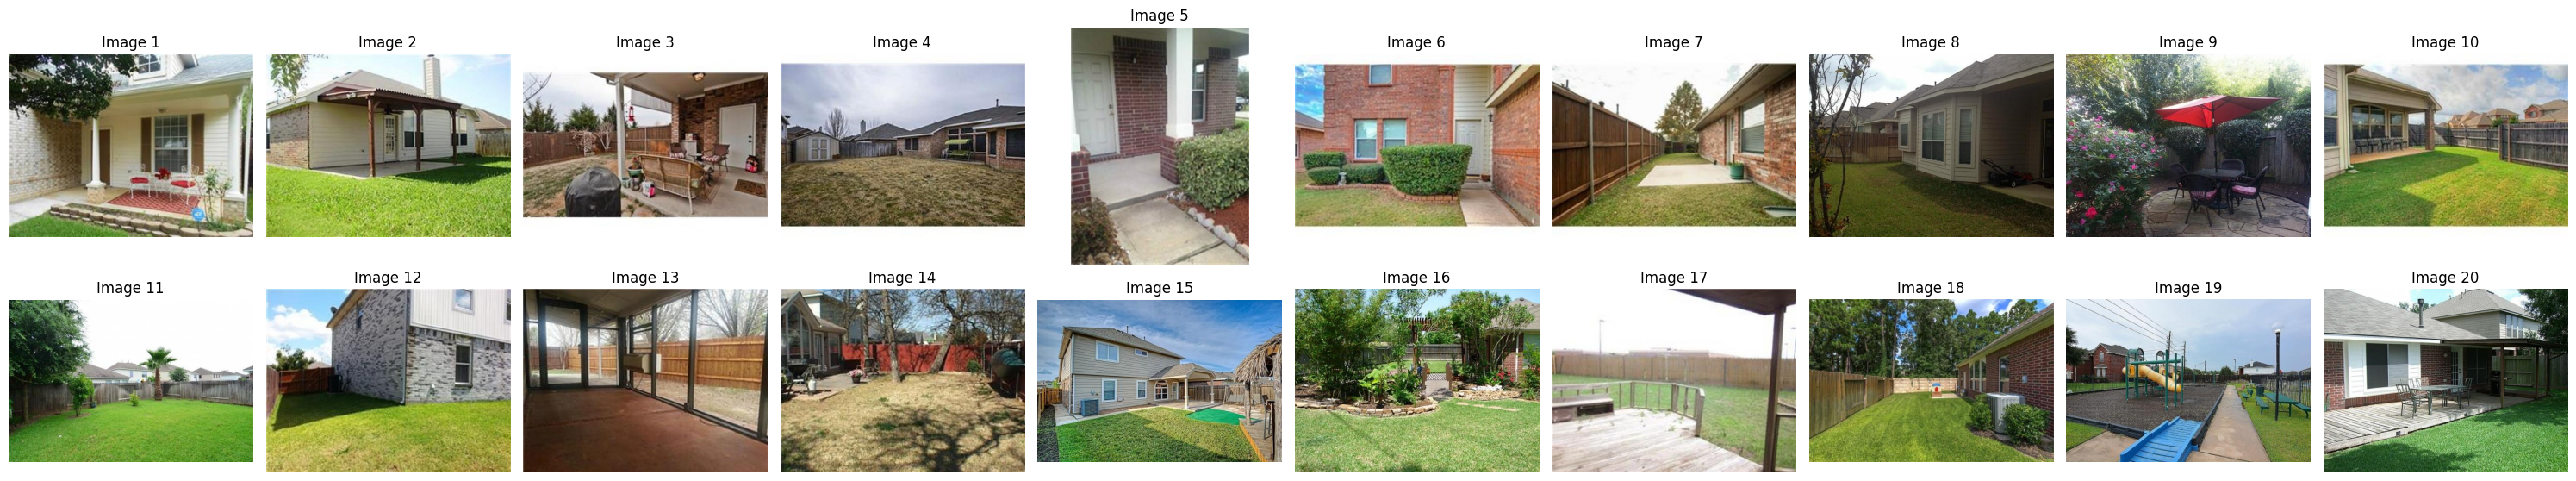

Average Precision for 20 images: 1.00


In [41]:
if __name__ == '__main__':
    # 1. Tải dataset và khởi tạo các folder
    df, folders = load_dataset()
    dataset = df.to_dict(orient='records')
    
    # Khởi tạo mô hình EfficientNetB7 với các trọng số ImageNet
    modelE = EfficientNetB7(weights=None, include_top=True, input_shape=(600, 600, 3))
    modelE.load_weights(base_dir + '/weights/' + 'efficientnetb7.h5')
    
    # Nếu bạn muốn loại bỏ lớp cuối cùng của mô hình
    modelE = Model(inputs=modelE.input, outputs=modelE.layers[-2].output)
    modelE.trainable = False
    
    # 3. Trích xuất đặc trưng
    all_features = extract_features(dataset, folders, modelE)

    # 4. Khởi tạo LabelEncoder
    le = LabelEncoder()
    labels = [item['label'] for item in dataset]
    labels_encoded = le.fit_transform(labels)

    # Lọc các nhãn hợp lệ
    valid_labels = [label for label in le.classes_ if label in all_features and len(all_features[label][0]) > 0]

    features_combined = np.concatenate([all_features[label][0] for label in le.classes_], axis=0)
    labels_combined = np.concatenate([le.transform([label] * len(all_features[label][1])) for label in valid_labels], axis=0)
    print("features_combined shape:", features_combined.shape)

    # Tiến hành chia dữ liệu nếu có dữ liệu hợp lệ
    if features_combined.size > 0 and labels_combined.size > 0:
        filenames = [item['filename'] for item in dataset][:len(features_combined)]
        X_train, X_test, y_train, y_test, train_files, test_files = train_test_split(
            features_combined, labels_combined, filenames, 
            test_size=0.2, random_state=42, stratify=labels_combined)
        print("Training and test datasets created successfully.")


        # 6. Huấn luyện mô hình SVM và đánh giá mô hình
        svm_model = train_svm_classifier(X_train, y_train)
        evaluate_classifier(svm_model, X_test, y_test, test_files, le)

        # Đường dẫn tới thư mục ảnh dùng để truy vấn
        main_folder = base_dir + '/REI-Dataset'
        image_paths = get_image_paths(main_folder)

        # 7. Nhập đường dẫn đến ảnh truy vấn từ người dùng
        print("Enter the path to an image (type 'exit' to quit):")
        while True:
            query_image_path = input().strip()
            if query_image_path.lower() == 'exit':
                break
            if os.path.exists(query_image_path):
                try:
                    retrived_image = cv2.imread(query_image_path)
                    retrived_image = cv2.cvtColor(retrived_image, cv2.COLOR_BGR2RGB)
                    plt.imshow(retrived_image)
                    top_n = 20
                    # Trích xuất đặc trưng và dự đoán nhãn của ảnh truy vấn
                    retrieved_images, query_label_predicted = retrieve_similar_images_from_query(
                        query_image_path, svm_model, all_features, modelE, le, top_n
                    )
                    
                    # Hiển thị các ảnh đã tìm thấy
                    display_images(retrieved_images, query_label_predicted)

                    # Tính toán AP
                    average_precision = calculate_ap(
                        query_label_predicted, retrieved_images, top_n)
                    print(f"Average Precision for {top_n} images: {average_precision:.2f}")
                except ValueError as e:
                    print(f"Error: {e}")
            else:
                print(f"Error: Path '{query_image_path}' does not exist.")